In [1]:
# pip install xlrd seaborn statsmodels.tsa.arima.model

ERROR: Could not find a version that satisfies the requirement sklearn.impute (from versions: none)
ERROR: No matching distribution found for sklearn.impute
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-06-23 11:19:47.564843: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 11:19:48.586332: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-23 11:19:52.406887: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 11:19:55.902094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
grocery_data = pd.read_csv("./data/Merged_final_deep.csv")

# We will parse date column as datetime and set as index
grocery_data['Date'] = pd.to_datetime(grocery_data['Date'])
grocery_data.set_index('Date', inplace=True)

# Load weather data
weather_data = pd.read_excel('./WeatherData.xlsx', engine='openpyxl')
weather_data['Dates'] = pd.to_datetime(weather_data['Dates'])
weather_data.set_index('Dates', inplace=True)

weather_data = weather_data.drop(['wdir','wspd','wpgt','pres','tsun'], axis=1)

/tmp/ipykernel_4679/171324238.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  grocery_data = pd.read_csv("./data/Merged_final_deep.csv")


In [3]:
import pandas as pd

# # Convert 'Date' column to datetime format
# grocery_data['Date'] = pd.to_datetime(grocery_data['Date'], errors='coerce')

# Ensure 'Description' is a string
grocery_data['Description'] = grocery_data['Description'].astype(str)

# Ensure 'Qty Sold' is numeric
grocery_data['Qty Sold'] = pd.to_numeric(grocery_data['Qty Sold'], errors='coerce')

# Pivot the data
grocery_data = grocery_data.pivot_table(index='Date', columns='Description', values='Qty Sold', aggfunc='sum')
grocery_data = grocery_data.drop('Description', axis=1)

# Fill any NaN values that occur during pivoting
grocery_data.fillna(0, inplace=True)

grocery_data.head()

Description,100 COFFEE FILTERS,100 GRAND,100 Grand,13 candles,14 Candles,15 balloons,16 Candles,16 Red Solo Cups,160cups,1911 Blueberry Hard Cider\n4PK,...,strong and soft,tomato soup,toothbrushes,triscuit,vo5 Conditioner,vo5 extra body conditoner,vo5 moisturizing shampoo,whole wheat bread,xtra care Hand sanitizer,zzzQuil
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-15,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Resample data to weekly by summing daily sales
grocery_data = grocery_data.resample('W').sum()
weather_data = weather_data.resample('W').mean()

In [5]:
weather_data = weather_data.drop(['2022-08-07', '2022-08-14'])

In [6]:
grocery_data.head()

Description,100 COFFEE FILTERS,100 GRAND,100 Grand,13 candles,14 Candles,15 balloons,16 Candles,16 Red Solo Cups,160cups,1911 Blueberry Hard Cider\n4PK,...,strong and soft,tomato soup,toothbrushes,triscuit,vo5 Conditioner,vo5 extra body conditoner,vo5 moisturizing shampoo,whole wheat bread,xtra care Hand sanitizer,zzzQuil
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-21,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2022-09-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-11,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-09-18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [7]:
total_sales = grocery_data.sum()

# Sort the total sales in ascending order
sorted_sales = total_sales.sort_values()

columns = sorted_sales[sorted_sales>=20].index.tolist()
grocery_data=grocery_data[columns]
grocery_data

Description,Orbit White Peppermint,Maruchan Roast Chicken,KESHAV TURMERIC\nPOWDER,Angry Orchard Green Apple\n6PK,Four Loko Strawberry\nLemonade,Genesee Beer 24oz,MILLER LITE 9PK,Cheez- It Grab n Go,Popcorners Sea Salt,Always Classic 10 Pads,...,Molson Ice 24oz Can,Vitamin D Whole Milk 1/2 Gallo,Coors Light 24oz,Goldhen Large Eggs,Fireball,Budweiser 25 OZ,Natural Ice 25oz,Milwaukees Best Ice CAN,NATTY DADDY 25OZ,GROCERY
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-21,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,32.0,10.0,25.0,12.0,39.0,47.0,63.0,37.0,62.0,638.0
2022-08-28,0.0,0.0,0.0,0.0,5.0,6.0,0.0,0.0,0.0,0.0,...,30.0,15.0,51.0,28.0,38.0,65.0,37.0,30.0,58.0,648.0
2022-09-04,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,25.0,12.0,28.0,8.0,32.0,38.0,44.0,27.0,34.0,707.0
2022-09-11,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,...,9.0,13.0,35.0,0.0,33.0,27.0,41.0,27.0,40.0,808.0
2022-09-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,14.0,13.0,11.0,7.0,42.0,24.0,31.0,14.0,35.0,737.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,12.0,10.0,19.0,3.0,31.0,44.0,108.0,68.0,1513.0
2024-03-03,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,23.0,20.0,8.0,17.0,5.0,44.0,27.0,108.0,76.0,1460.0
2024-03-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,28.0,9.0,8.0,15.0,1.0,37.0,26.0,88.0,59.0,1443.0


In [8]:
grocery_columns = grocery_data.columns
weather_columns = weather_data.columns

In [9]:
# Normalize/scale both datasets (if not already done)
from sklearn.preprocessing import MinMaxScaler

scaler_grocery = MinMaxScaler()
sales_data_scaled = scaler_grocery.fit_transform(grocery_data)

scaler_weather = MinMaxScaler()
weather_data_scaled = scaler_weather.fit_transform(weather_data)

# Combine scaled data back into a single DataFrame for sequence creation
grocery_data_scaled = pd.concat([pd.DataFrame(sales_data_scaled, index=grocery_data.index, columns=grocery_columns),
                               pd.DataFrame(weather_data_scaled, index=weather_data.index, columns=weather_columns)], axis=1)

### Add Holidays column

In [10]:
holidays = [
    '2022-09-05', '2022-10-10',
    '2022-11-11', '2022-11-24',
    '2022-12-25', '2023-01-01', 
    '2023-01-16', '2023-02-20',
    '2023-05-29', '2023-06-19',
    '2023-07-04', '2023-09-04',
    '2023-10-09', '2023-11-11', 
    '2023-11-23', '2023-12-25',
    '2024-01-01', '2024-01-15',
    '2024-02-19',
]

holiday_dates = pd.to_datetime(pd.Series(holidays))

# Initialize a list to store the holiday flags
holiday_flags = []

# Iterate over the dates in the grocery dataset
for date in grocery_data_scaled.index:
    # Get the start and end of the week containing the current date
    week_start = date - timedelta(days=date.weekday())
    week_end = week_start + timedelta(days=6)
    
    # Check if any holiday falls in the current week
    if any(week_start <= holiday <= week_end for holiday in holiday_dates):
        holiday_flags.append(1)
    else:
        holiday_flags.append(0)

# Add the holiday flags to the grocery dataset
grocery_data_scaled['holidays'] = holiday_flags

### Getting Sequences

In [29]:
import numpy as np

# Convert to numpy array if it's not already one
if not isinstance(grocery_data_scaled, np.ndarray):
    grocery_data_scaled = np.array(grocery_data_scaled)

# Print the shape of the array
print("Shape of grocery_data_scaled:", grocery_data_scaled.shape)

# Define parameters
n_future = 1
n_past = 8

# Initialize lists to hold the training data
trainX = []
trainY = []

# Loop through the dataset to construct the training data
for i in range(n_past, len(grocery_data_scaled) - n_future + 1):
    x_start = i - n_past
    x_end = i
    y_index = i + n_future - 1
    
    try:
        # Slice the data for the current window
        x = grocery_data_scaled[x_start:x_end, :]  # shape should be (n_past, 1273)
        y = grocery_data_scaled[y_index, :1267]    # shape should be (1267,)

        # Append the sliced data to the lists
        trainX.append(x)
        trainY.append(y)
    except Exception as e:
        print(f"Error encountered: {e}")
        break

# Convert lists to numpy arrays
trainX = np.array(trainX)
trainY = np.array(trainY)

# Print the final shapes of trainX and trainY
print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)

Shape of grocery_data_scaled: (84, 1273)
trainX shape: (76, 8, 1273)
trainY shape: (76, 1267)


### Model Building

In [35]:
# Define split sizes
train_size = int(0.6 * len(trainX))
val_size = int(0.2 * len(trainX))
test_size = len(trainX) - train_size - val_size

# Split the data
trainX_train = trainX[:train_size]
trainY_train = trainY[:train_size]

trainX_val = trainX[train_size:train_size + val_size]
trainY_val = trainY[train_size:train_size + val_size]

trainX_test = trainX[train_size + val_size:]
trainY_test = trainY[train_size + val_size:]

print("Train set shapes:", trainX_train.shape, trainY_train.shape)
print("Validation set shapes:", trainX_val.shape, trainY_val.shape)
print("Test set shapes:", trainX_test.shape, trainY_test.shape)

Train set shapes: (45, 8, 1273) (45, 1267)
Validation set shapes: (15, 8, 1273) (15, 1267)
Test set shapes: (16, 8, 1273) (16, 1267)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define constants for the model
n_past = 8
n_features = 1273
n_grocery_items = 1267

# Build the model
model = Sequential()

# First LSTM layer with return_sequences=True to pass the sequence to the next layer
model.add(LSTM(64, activation='relu', input_shape=(n_past, n_features), return_sequences=True))

# Second LSTM layer with return_sequences=True for CNN processing
model.add(LSTM(32, activation='relu', return_sequences=True))

# Adding a Conv1D layer for feature extraction from sequences
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Adding a Dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Adding a Dense layer for final prediction
model.add(Dense(n_grocery_items))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 8, 64)          │       342,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 8, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1267)           │       163,443 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,491 (2.13 MB)

 Trainable params: 557,491 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train the model
history = model.fit(trainX_train, trainY_train, epochs=50, batch_size=16, validation_data=(trainX_val, trainY_val))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - loss: 0.0743 - mae: 0.1504 - val_loss: 0.0640 - val_mae: 0.1394
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0692 - mae: 0.1586 - val_loss: 0.0587 - val_mae: 0.1482
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0644 - mae: 0.1656 - val_loss: 0.0541 - val_mae: 0.1528
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0570 - mae: 0.1667 - val_loss: 0.0510 - val_mae: 0.1563
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0527 - mae: 0.1646 - val_loss: 0.0499 - val_mae: 0.1573
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0506 - mae: 0.1634 - val_loss: 0.0496 - val_mae: 0.1573
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0497 - mae: 0.1622 - val_loss: 0.0494 - val_mae: 0.1585

In [39]:
# Evaluate the model
test_loss, test_mae = model.evaluate(trainX_test, trainY_test)
print('Test loss:', test_loss)
print('Test MAE:', test_mae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0520 - mae: 0.1543
Test loss: 0.05204232037067413
Test MAE: 0.1543174833059311


In [40]:
# Make predictions
predictions = model.predict(trainX_test)

# Inverse transform the sales data
predictions_sales_original = scaler_grocery.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


In [42]:
predictions_sales_original.shape

(16, 1267)

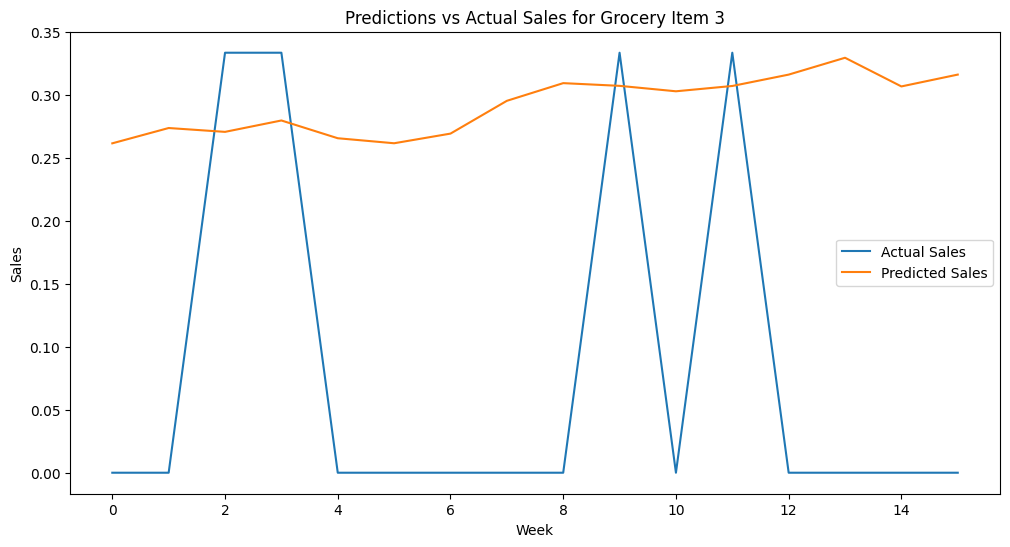

In [45]:
# Plot predictions vs actual values for the first grocery item
grocery_item_index = 2

plt.figure(figsize=(12, 6))
plt.plot(trainY_test[:, grocery_item_index], label='Actual Sales')
plt.plot(predictions_sales_original[:, grocery_item_index], label='Predicted Sales')
plt.title(f'Predictions vs Actual Sales for Grocery Item {grocery_item_index+1}')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.legend()
plt.show()